# EN160 Assignment 2 on Fitting and Alignment # 

# Simple blob detection 


(-0.5, 359.5, 359.5, -0.5)

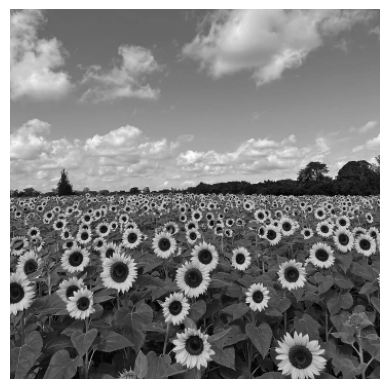

In [33]:
import cv2
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

# Load and convert the image
im = cv2.imread('images/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).astype(np.float32)

#show the image
plt.imshow(im_gray, cmap='gray')
plt.axis('off')

Image shape: (360, 360, 3)
Grayscale shape: (360, 360)
Building scale space with 10 scales...
Processing sigma = 1.00 (1/10)
Processing sigma = 1.29 (2/10)
Processing sigma = 1.67 (3/10)
Processing sigma = 2.15 (4/10)
Processing sigma = 2.78 (5/10)
Processing sigma = 3.59 (6/10)
Processing sigma = 4.64 (7/10)
Processing sigma = 5.99 (8/10)
Processing sigma = 7.74 (9/10)
Processing sigma = 10.00 (10/10)
Finding scale-space extrema...
Detected 365 blobs

RESULTS

Sigma range used: [1.00, 10.00]
Number of sigma values: 10

Total blobs detected: 365

--- Top 10 Largest Circles ---
1. Center: (293, 168), Sigma: 10.00, Radius: 14.14, Response: 0.2329
2. Center: (336, 161), Sigma: 10.00, Radius: 14.14, Response: 0.2227
3. Center: (282, 338), Sigma: 7.74, Radius: 10.95, Response: 0.3432
4. Center: (0, 275), Sigma: 7.74, Radius: 10.95, Response: 0.3406
5. Center: (334, 156), Sigma: 7.74, Radius: 10.95, Response: 0.2050
6. Center: (178, 261), Sigma: 5.99, Radius: 8.48, Response: 0.3445
7. Center

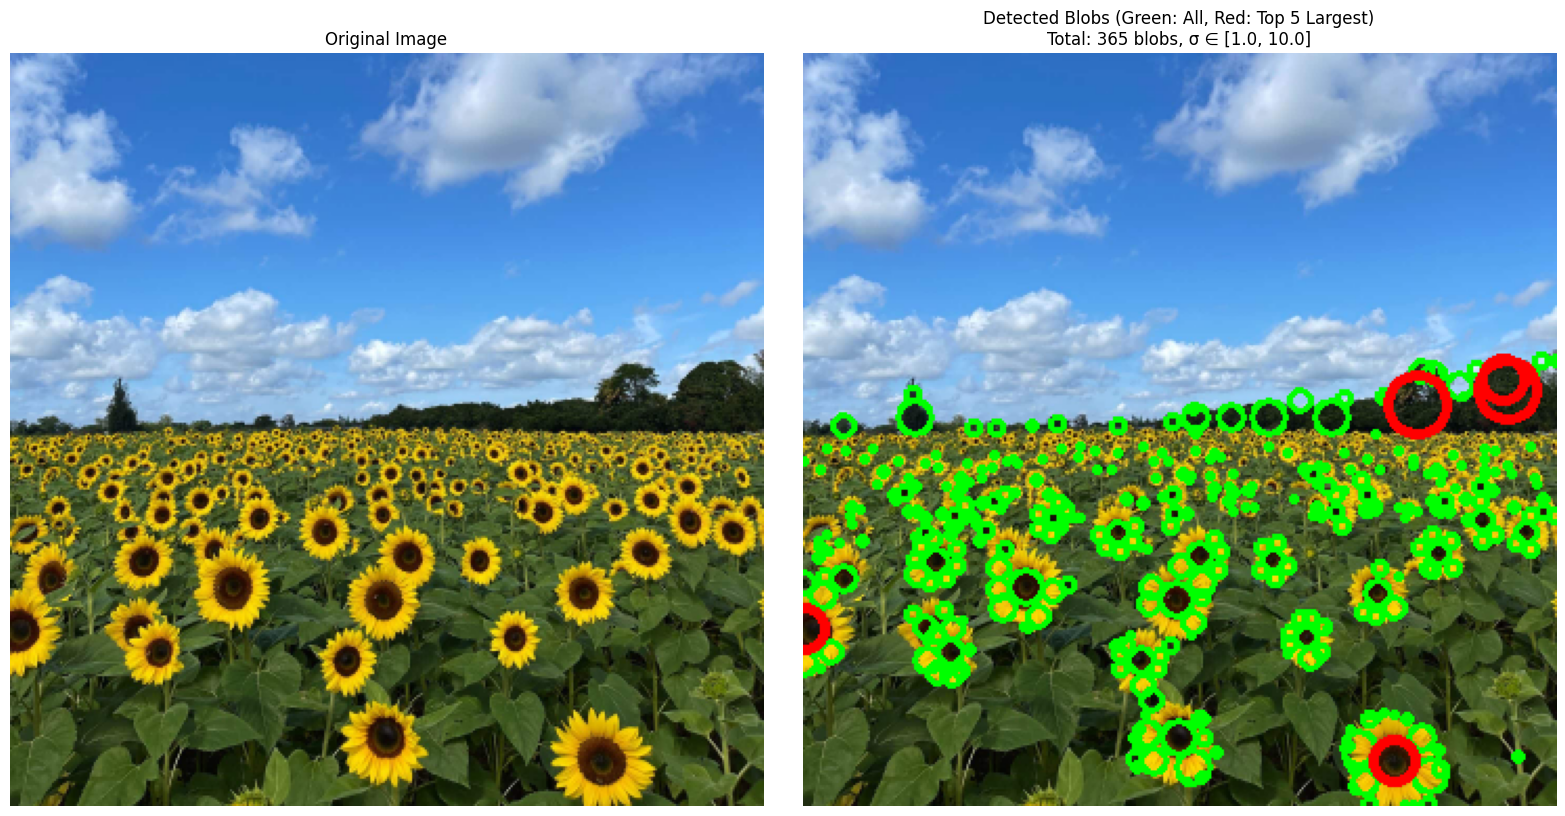


Visualization saved as 'sunflower_blob_detection_result.png'


In [46]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def compute_log_response(image, sigma):
    """
    Compute the Laplacian of Gaussian response for a given sigma.
    The response is normalized by sigma^2 for scale invariance.
    """
    # Apply Gaussian smoothing
    smoothed = cv.GaussianBlur(image, (0, 0), sigma)
    
    # Compute Laplacian using cv2.Laplacian
    laplacian = cv.Laplacian(smoothed, cv.CV_64F)
    
    # Normalize by sigma^2 for scale invariance
    return sigma**2 * np.abs(laplacian)

def detect_blobs_log(image, sigma_min=5, sigma_max=50, num_sigma=20, threshold=0.01):
    """
    Detect blobs using Laplacian of Gaussian across multiple scales.
    
    Parameters:
    - image: grayscale input image
    - sigma_min: minimum sigma value
    - sigma_max: maximum sigma value
    - num_sigma: number of sigma values to test
    - threshold: threshold for blob detection (relative to max response)
    
    Returns:
    - blobs: array of detected blobs (y, x, sigma)
    """
    # Generate sigma values (logarithmic spacing works well)
    sigma_values = np.logspace(np.log10(sigma_min), np.log10(sigma_max), num_sigma)
    
    # Normalize image to [0, 1]
    image_normalized = image.astype(np.float64) / 255.0
    
    # Build scale space
    print(f"Building scale space with {num_sigma} scales...")
    scale_space = np.zeros((len(sigma_values), image.shape[0], image.shape[1]))
    
    for i, sigma in enumerate(sigma_values):
        print(f"Processing sigma = {sigma:.2f} ({i+1}/{num_sigma})")
        scale_space[i] = compute_log_response(image_normalized, sigma)
    
    # Find local maxima in scale space
    print("Finding scale-space extrema...")
    
    # Compute absolute threshold
    abs_threshold = threshold * np.max(scale_space)
    
    # Find local maxima using maximum filter
    # A point is a local maximum if it equals the maximum in its neighborhood
    local_max = ndimage.maximum_filter(scale_space, size=(3, 3, 3))
    detected_blobs = (scale_space == local_max) & (scale_space > abs_threshold)
    
    # Extract blob coordinates
    blobs_indices = np.argwhere(detected_blobs)
    
    blobs = []
    for idx in blobs_indices:
        sigma_idx, y, x = idx
        sigma = sigma_values[sigma_idx]
        response = scale_space[sigma_idx, y, x]
        blobs.append([y, x, sigma, response])
    
    blobs = np.array(blobs)
    print(f"Detected {len(blobs)} blobs")
    
    return blobs, sigma_values

def draw_circles(image, blobs, color=(0, 255, 0), thickness=2):
    """
    Draw circles on the image based on detected blobs.
    The radius is sqrt(2) * sigma for LoG blobs.
    """
    output = image.copy()
    
    for blob in blobs:
        y, x, sigma = blob[:3]
        # Radius for LoG blob is sqrt(2) * sigma
        radius = int(np.sqrt(2) * sigma)
        cv.circle(output, (int(x), int(y)), radius, color, thickness)
    
    return output

# Load the image
im = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

if im is None:
    print("Error: Could not load image. Please check the path.")
else:
    # Convert to grayscale
    gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    print(f"Image shape: {im.shape}")
    print(f"Grayscale shape: {gray.shape}")
    
    # Detect blobs using LoG
    # Adjust these parameters based on expected sunflower sizes
    blobs, sigma_values = detect_blobs_log(
        gray,
        sigma_min=1,      # Minimum sigma
        sigma_max=10,     # Maximum sigma
        num_sigma=10,     # Number of scales to test
        threshold=0.5  # Detection threshold (lower = more detections)
    )
    
    # Sort blobs by size (sigma) in descending order
    blobs_sorted = blobs[np.argsort(blobs[:, 2])[::-1]]
    
    # Report largest circles
    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"\nSigma range used: [{sigma_values[0]:.2f}, {sigma_values[-1]:.2f}]")
    print(f"Number of sigma values: {len(sigma_values)}")
    print(f"\nTotal blobs detected: {len(blobs)}")
    
    print("\n--- Top 10 Largest Circles ---")
    for i, blob in enumerate(blobs_sorted[:10]):
        y, x, sigma, response = blob
        radius = np.sqrt(2) * sigma
        print(f"{i+1}. Center: ({int(x)}, {int(y)}), Sigma: {sigma:.2f}, "
              f"Radius: {radius:.2f}, Response: {response:.4f}")
    
    # Draw all detected circles
    result = draw_circles(im, blobs, color=(0, 255, 0), thickness=2)
    
    # Draw top 5 largest circles in red for visibility
    result = draw_circles(result, blobs_sorted[:5], color=(0, 0, 255), thickness=3)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image
    axes[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Result with detected circles
    axes[1].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    axes[1].set_title(f'Detected Blobs (Green: All, Red: Top 5 Largest)\n'
                      f'Total: {len(blobs)} blobs, σ ∈ [{sigma_values[0]:.1f}, {sigma_values[-1]:.1f}]')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig('sunflower_blob_detection_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("Visualization saved as 'sunflower_blob_detection_result.png'")
    print("="*60)